**Importing all the required Libraries**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import os
import random
from sklearn.model_selection import train_test_split



**Visualizing the Data Distribution**

      Eyeclose  Yawn  Neutral
Sub1       157    58      166
Sub2       316    51      167
Sub3       145    60       88


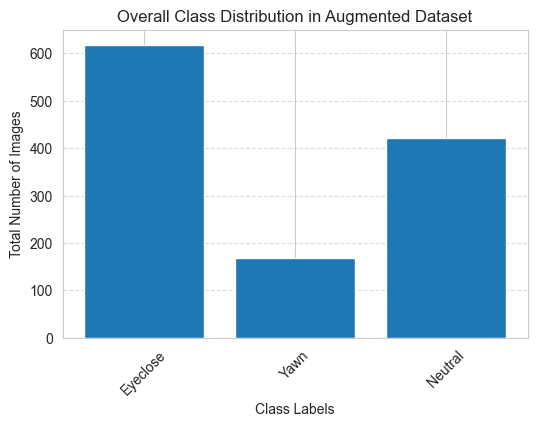

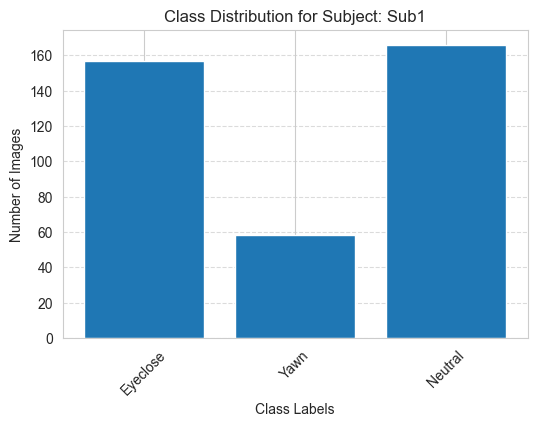

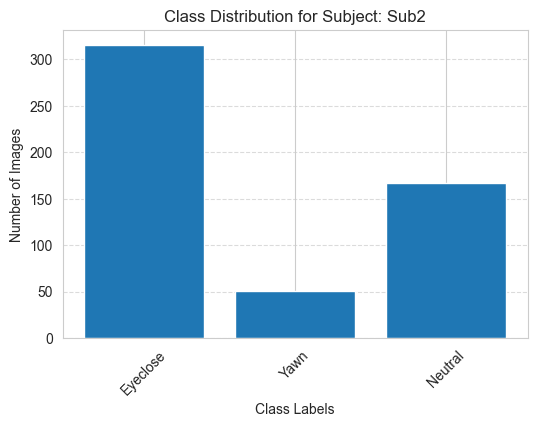

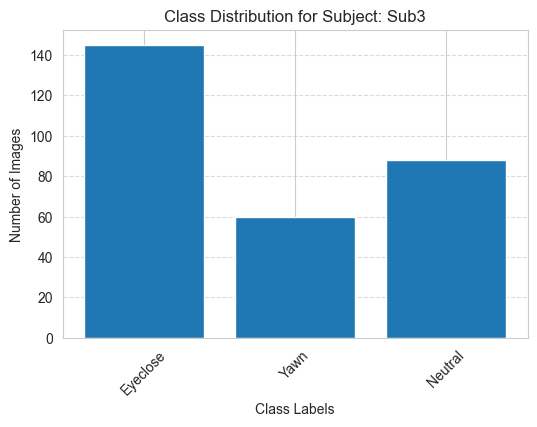

In [17]:
# Define dataset path
DATASET_PATH = "D3SSubjectData"

# Define label mappings
LABELS = {'Eyeclose': 0, 'Yawn': 1, 'Neutral': 2} # Dataset consists of 3 distinct subjects each containing labelled frames with Eyeclose, Neutral and Yawn

# Initialize dictionary to store subject-wise class distribution
subject_class_distribution = {}

# Iterate through each subject folder
for subject in sorted(os.listdir(DATASET_PATH)):  # Ensure sorted order for consistency
    subject_path = os.path.join(DATASET_PATH, subject)
    if not os.path.isdir(subject_path):
        continue  # Skip if not a directory

    # Initialize class counts for this subject
    class_counts = Counter()

    # Iterate through each class category (Eyeclose, Yawn, Neutral)
    for category in LABELS.keys():
        category_path = os.path.join(subject_path, category)
        if not os.path.exists(category_path):
            continue  # Skip if category folder doesn't exist

        num_images = len(os.listdir(category_path))  # Count number of images
        class_counts[category] = num_images  # Store count

    # Store the class distribution for this subject
    subject_class_distribution[subject] = class_counts

# Convert to Pandas DataFrame for better visualization
df_distribution = pd.DataFrame.from_dict(subject_class_distribution, orient="index").fillna(0)
# Print for debugging
print(df_distribution)

import matplotlib.pyplot as plt
from collections import Counter

# Sum class distributions across all subjects
total_distribution = Counter()
for class_counts in subject_class_distribution.values():
    total_distribution.update(class_counts)

# Convert to lists for plotting
class_labels = list(total_distribution.keys())
class_counts = list(total_distribution.values())

# Plot total distribution
plt.figure(figsize=(6, 4))
plt.bar(class_labels, class_counts)
plt.xlabel("Class Labels")
plt.ylabel("Total Number of Images")
plt.title("Overall Class Distribution in Augmented Dataset")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


for subject, class_counts in subject_class_distribution.items():
    plt.figure(figsize=(6, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution for Subject: {subject}")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [18]:
# Define dataset path
DATASET_PATH = "D3SSubjectData"  # Replace with actual dataset path

# Define Label Mappings
LABELS = {'Eyeclose': 0, 'Yawn': 1, 'Neutral': 2}

# Initialize dictionary to store subject-wise data
dataset_data = {}

# Loop through each subject in the dataset folder
for subject in sorted(os.listdir(DATASET_PATH)):  # Ensure sorted order for consistency
    subject_path = os.path.join(DATASET_PATH, subject)

    if os.path.isdir(subject_path):  # Ensure it's a directory
        subject_data = []

        # Loop through each category (Eyeclose, Yawn, Neutral)
        for category, label in LABELS.items():
            category_path = os.path.join(subject_path, category)

            if os.path.exists(category_path):  # Ensure category folder exists
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    subject_data.append((img_path, label))  # Store image path and label

        # Store subject data in dictionary
        dataset_data[subject] = subject_data

# Convert to DataFrame for better visualization
df_dataset = {subj: pd.DataFrame(data, columns=["image_path", "label"]) for subj, data in dataset_data.items()}

# Print summary
for subject, df in df_dataset.items():
    print(f"Subject: {subject}, Total Images: {len(df)}")
    print(df["label"].value_counts(), "\n")

Subject: Sub1, Total Images: 381
label
2    166
0    157
1     58
Name: count, dtype: int64 

Subject: Sub2, Total Images: 534
label
0    316
2    167
1     51
Name: count, dtype: int64 

Subject: Sub3, Total Images: 293
label
0    145
2     88
1     60
Name: count, dtype: int64 



**Preparing train, validation and test sets**

In [19]:
# Extract Subjects Data
subject_1_data = dataset_data["Sub1"]
subject_2_data = dataset_data["Sub2"]
subject_3_data = dataset_data["Sub3"]
# Convert to DataFrame for easier manipulation
df_sub1 = pd.DataFrame(subject_1_data, columns=["image_path", "label"])
df_sub2 = pd.DataFrame(subject_2_data, columns=["image_path", "label"])
df_sub3= pd.DataFrame(subject_3_data, columns=["image_path", "label"])

train_df=pd.concat([df_sub1,df_sub2])
# val_df = pd.concat([df_sub2])
test_df = pd.concat([df_sub3])
# Stratified Split: 50% for validation, 50% for testing
train_data, val_data = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["label"],  # Maintain class distribution
    random_state=42  # Ensure reproducibility
)

# Convert back to lists
# train_set=list(zip(train_df["image_path"], train_df["label"]))
# val_set = list(zip(val_df["image_path"], val_df["label"]))

train_set=list(zip(train_data["image_path"], train_data["label"]))
val_set = list(zip(val_data["image_path"], val_data["label"]))
test_set = list(zip(test_df["image_path"], test_df["label"]))
# Print distributions to verify balance
train_counts = pd.Series([label for _, label in train_set]).value_counts()
val_counts = pd.Series([label for _, label in val_set]).value_counts()
test_counts = pd.Series([label for _, label in test_set]).value_counts()

print("Train Set Class Distribution:\n", train_counts)
print("Validation Set Class Distribution:\n", val_counts)
print("\nTest Set Class Distribution:\n", test_counts)


Train Set Class Distribution:
 0    402
2    283
1     92
Name: count, dtype: int64
Validation Set Class Distribution:
 0    71
2    50
1    17
Name: count, dtype: int64

Test Set Class Distribution:
 0    145
2     88
1     60
Name: count, dtype: int64


**Loading and Transforming data**

In [20]:

# Define Label Mappings
LABELS = {'Eyeclose': 0, 'Yawn': 1, 'Neutral': 2}

# Define Image Size
IMG_SIZE = (224, 224)

# Define preprocessing transform for ResNet34
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.RandomResizedCrop(224, antialias=True),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
val_transforms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class DriverDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Error loading image: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)

        if self.transform:
            image = self.transform(image)

        return image, label
        

In [21]:
# Create Datasets
train_dataset = DriverDataset(train_set, transform=train_transforms)
val_dataset = DriverDataset(val_set, transform=val_transforms)
test_dataset = DriverDataset(test_set, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Train Data: {len(train_dataset)} images")
print(f"Validation Data: {len(val_dataset)} images")
print(f"Test Data: {len(test_dataset)} images")


Train Data: 777 images
Validation Data: 138 images
Test Data: 293 images


**Visualizig samples from train, validation and test set**

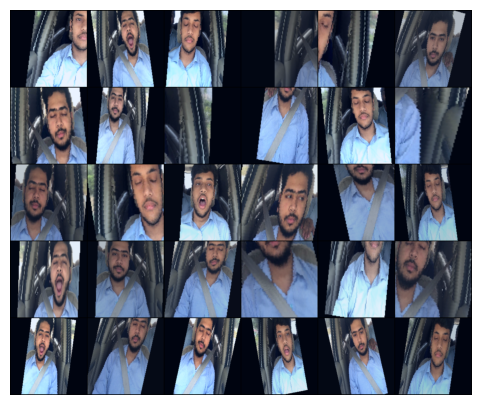

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select 8 images from the batch
images = images[:30]

# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=6, normalize=True)

# Convert to numpy for displaying
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

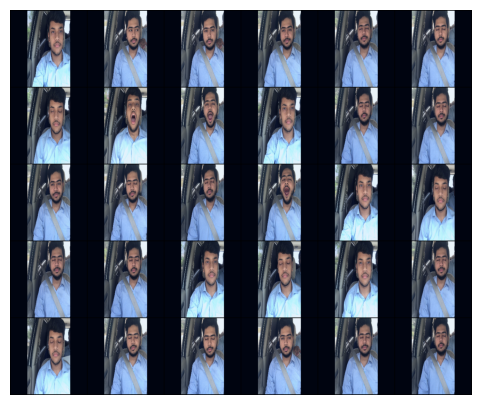

In [23]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Select 8 images from the batch
images = images[:30]

# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=6, normalize=True)

# Convert to numpy for displaying
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

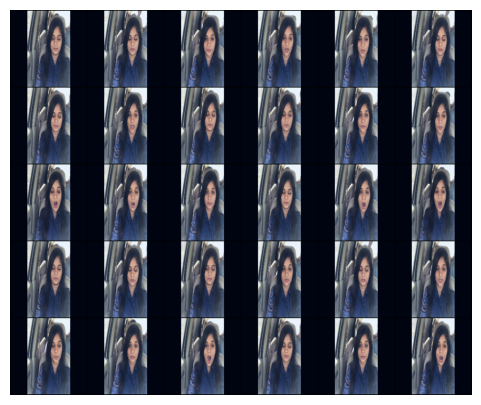

In [23]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select 8 images from the batch
images = images[:30]

# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=6, normalize=True)

# Convert to numpy for displaying
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device is : ", device)

Available Device is :  cpu


**Creating Resnet34 Classifier for fine tuning**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

# Define ResNet34 Classifier with Dropout
class ResNet34Classifier(nn.Module):
    def __init__(self, num_classes=3, dropout_prob=0.3):
        super(ResNet34Classifier, self).__init__()
        self.model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        # Freeze all layers except the last one
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and FC layer
        for name, param in self.model.layer4.named_parameters():
            param.requires_grad = True

        for name, param in self.model.fc.named_parameters():
            param.requires_grad = True

        # Modify layer4 to add dropout after each convolution
        self.model.layer4 = nn.Sequential(
            self.model.layer4,
            nn.Dropout(dropout_prob)  # Dropout between convolutional layers
        )

        # Modify FC layer to include dropout before classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, class_weights , model_name, lr=0.001, weight_decay=0.0001, scheduler_patience=3, scheduler_factor=0.5, num_epochs=15, early_stop_patience=5):
    # Define loss function & optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau scheduler: reduces LR when validation loss stops improving
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=scheduler_patience, factor=scheduler_factor, verbose=True)

    # Initialize tracking variables
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
            optimizer.step()

            train_loss += loss.item()

        # Compute average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # Compute average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model, f"{model_name}.pth") # Save best model
            print("Model Improved. Saving Model.")
        else:
            early_stop_counter += 1
            print(f"No Improvement for {early_stop_counter} epochs.")

        if early_stop_counter >= early_stop_patience:
            print("Early Stopping Triggered! Training Stopped.")
            break  # Exit the training loop

        # Step the scheduler based on validation loss
        scheduler.step(val_loss)

    print(f"Training Complete. Best Model Saved as {model_name}")

    # Plot training and validation loss
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    

    return model  # Return trained model for further use


**Training the model**

/home/bashir/rehan/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 1.0499 - Val Loss: 0.8584 - Val Accuracy: 76.81%
Model Improved. Saving Model.
Epoch 2/50 - Train Loss: 0.7689 - Val Loss: 0.6290 - Val Accuracy: 83.33%
Model Improved. Saving Model.
Epoch 3/50 - Train Loss: 0.5804 - Val Loss: 0.4502 - Val Accuracy: 90.58%
Model Improved. Saving Model.
Epoch 4/50 - Train Loss: 0.4481 - Val Loss: 0.2750 - Val Accuracy: 96.38%
Model Improved. Saving Model.
Epoch 5/50 - Train Loss: 0.4073 - Val Loss: 0.4209 - Val Accuracy: 81.16%
No Improvement for 1 epochs.
Epoch 6/50 - Train Loss: 0.3471 - Val Loss: 0.3516 - Val Accuracy: 86.23%
No Improvement for 2 epochs.
Epoch 7/50 - Train Loss: 0.3306 - Val Loss: 0.2020 - Val Accuracy: 95.65%
Model Improved. Saving Model.
Epoch 8/50 - Train Loss: 0.3150 - Val Loss: 0.3587 - Val Accuracy: 87.68%
No Improvement for 1 epochs.
Epoch 9/50 - Train Loss: 0.3199 - Val Loss: 0.1113 - Val Accuracy: 97.10%
Model Improved. Saving Model.
Epoch 10/50 - Train Loss: 0.3180 - Val Loss: 0.2268 - Val Accuracy:

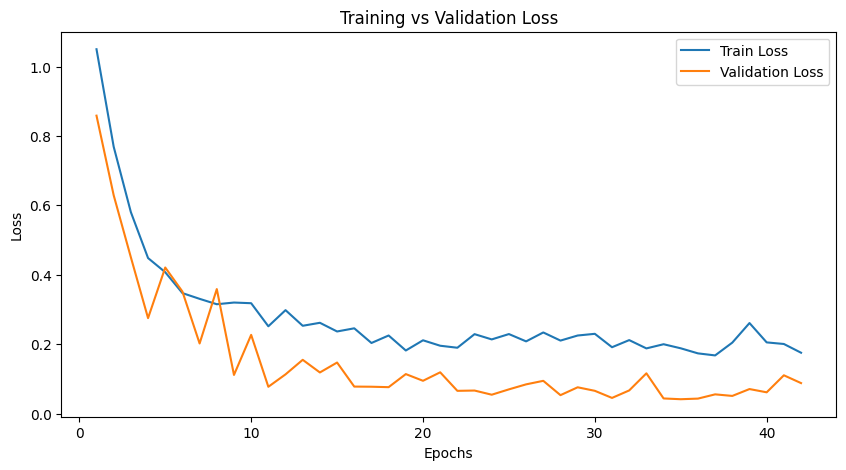

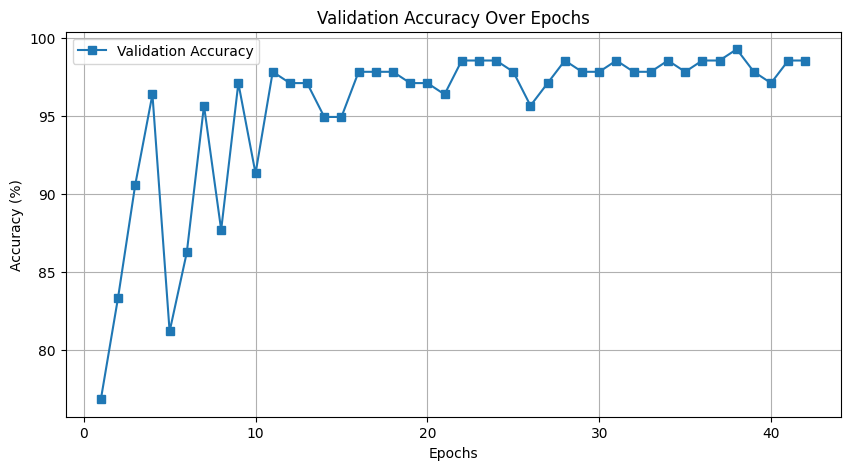

In [11]:
# Initialize Model
model = ResNet34Classifier(num_classes=3,dropout_prob=0.3).to(device)
# print(model)# Training function with ReduceLROnPlateau scheduler
model_name = 'resnet34_unweighted_hyperpara7_64batch_50_epochs'
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    None,
    model_name,
    lr= 3e-5,
    weight_decay=1e-4,
    scheduler_patience=3,  
    scheduler_factor=0.8,  
    num_epochs=50,
    early_stop_patience=7
)

**Testing the model on test data**

In [14]:
print(" Model Loaded for Inference")

model = torch.load("resnet34_unweighted_hyperpara7_64batch_50_epochs.pth", map_location=device, weights_only=False)

# Test the model
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f" **Test Accuracy: {test_accuracy:.2f}%**")


 Model Loaded for Inference
 **Test Accuracy: 91.47%**


**Classification Report and Confusion Matrix**


 Classification Report:
               precision    recall  f1-score   support

    Eyeclose       0.88      1.00      0.94       145
        Yawn       0.96      0.88      0.92        60
     Neutral       0.96      0.80      0.87        88

    accuracy                           0.91       293
   macro avg       0.93      0.89      0.91       293
weighted avg       0.92      0.91      0.91       293



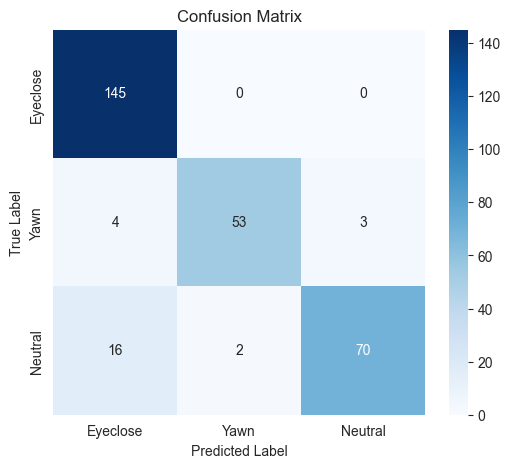

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ["Eyeclose", "Yawn", "Neutral"]
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
